In [6]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from plotly.subplots import make_subplots
import plotly.graph_objects as go



In [7]:
def load_images(image_dir, num_images=5):
    images = []
    for i, filename in enumerate(os.listdir(image_dir)):
        if i >= num_images:
            break
        img = cv2.imread(os.path.join(image_dir, filename))
        if img is not None:
            images.append(img)
    return images




In [8]:
def segment_image_with_pca(image, n_components=2, k=3):
    if image is None:
        print("Error: Invalid image")
        return None
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixel_values = image_rgb.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    pixel_values_reduced = pca.fit_transform(pixel_values)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(pixel_values_reduced)
    centers = kmeans.cluster_centers_
    
    # Map labels back to the original color space
    centers = pca.inverse_transform(centers)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image_rgb.shape)
    return segmented_image



In [9]:
def calculate_pixel_accuracy(pred, target):
    # Ensure both images are of the same shape
    if pred.shape != target.shape:
        raise ValueError("Shape mismatch: Prediction and target images must have the same shape.")
    
    # Flatten the arrays to 1D to avoid issues with elementwise comparison in 2D
    pred_flat = pred.flatten()
    target_flat = target.flatten()
    
    # Calculate accuracy as the proportion of matching pixels
    return np.mean(pred_flat == target_flat)


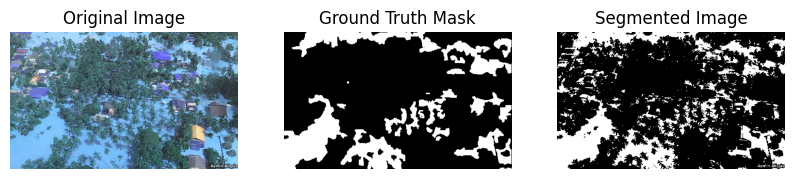

Side by side comparison saved as 'Image/side_by_side_comparison.png'


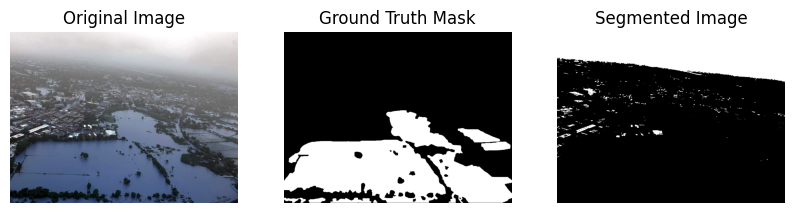

Side by side comparison saved as 'Image/side_by_side_comparison.png'


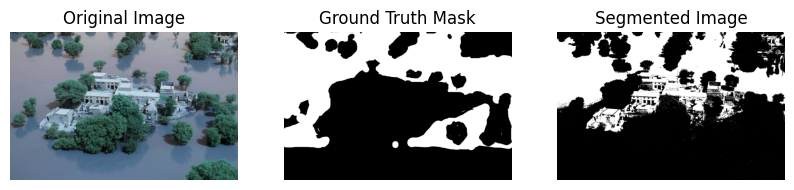

Side by side comparison saved as 'Image/side_by_side_comparison.png'


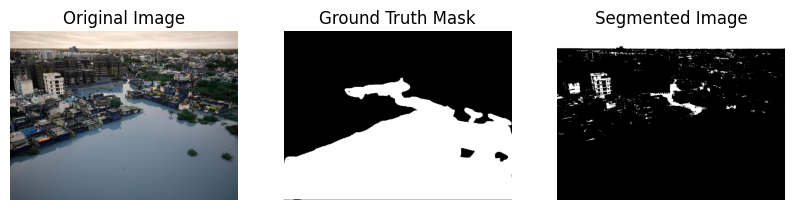

Side by side comparison saved as 'Image/side_by_side_comparison.png'


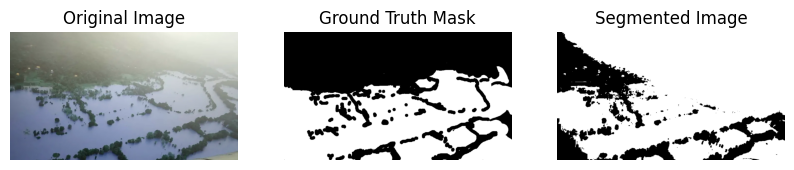

Side by side comparison saved as 'Image/side_by_side_comparison.png'
Average accuracy: 0.6235943580719993


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to resize the images to the same size
def resize_images_to_same_dimension(*images):
    # Get the minimum height and width
    min_height = min(image.shape[0] for image in images)
    min_width = min(image.shape[1] for image in images)
    
    resized_images = [cv2.resize(image, (min_width, min_height)) for image in images]
    return resized_images

# Convert the segmented image to black and white (binary)
def convert_to_black_and_white(image):
    # Convert to grayscale (if it's not already)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply thresholding to make it binary (black and white)
    _, bw_image = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
    return bw_image

# Ensure all images are 3D (with 3 channels) for concatenation
def convert_to_three_channels(image):
    return cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Compare the images
def compare_with_mask(segmented_image, mask, img, accuracies):
    # Convert images to grayscale
    ground_truth_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)  # Convert mask to grayscale
    segmented_image_resized = cv2.resize(segmented_image, (ground_truth_mask.shape[1], ground_truth_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Resize images to the same dimension
    image_resized, mask_resized, segmented_image_resized = resize_images_to_same_dimension(img, mask, segmented_image_resized)

    # Convert the segmented image to black and white
    segmented_image_bw = convert_to_black_and_white(segmented_image_resized)
    mask_resized_bw = convert_to_black_and_white(mask_resized)

    # Convert black and white images back to 3 channels
    mask_resized_bw_3d = convert_to_three_channels(mask_resized_bw)
    segmented_image_bw_3d = convert_to_three_channels(segmented_image_bw)

    # Calculate accuracy (binary comparison)
    accuracy = calculate_pixel_accuracy(segmented_image_bw, mask_resized_bw)
    accuracies.append(accuracy)
    
    # Plot the images side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_resized)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_resized_bw_3d, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(segmented_image_bw_3d, cmap='gray')
    plt.title("Segmented Image")
    plt.axis('off')

    plt.show()

    # Optionally save the images side by side as a single image
    side_by_side = np.concatenate([image_resized, mask_resized_bw_3d, segmented_image_bw_3d], axis=1)
    cv2.imwrite('Image/side_by_side_comparison.png', side_by_side)
    print("Side by side comparison saved as 'Image/side_by_side_comparison.png'")

# Example usage with your existing code
def main():
    k = 3  # Number of clusters for KMeans
    results = {'accuracy': []}  # Store accuracy for PCA method

    image_dir = 'Data/Image'  # Directory for input images
    mask_dir = 'Data/Mask'  # Directory for ground truth masks

    images = load_images(image_dir)  # Load images
    masks = load_images(mask_dir)  # Load masks

    # Loop through each image and corresponding mask
    for img, mask in zip(images, masks):
        # Segment the image using KMeans with PCA
        segmented_image = segment_image_with_pca(img, k=k)
        if segmented_image is not None:
            compare_with_mask(segmented_image, mask, img, results['accuracy'])

    # Print the average accuracy of the PCA method
    print(f"Average accuracy: {np.mean(results['accuracy'])}")

# Call the main function to run the segmentation and accuracy calculation
if __name__ == "__main__":
    main()


Processing for Threshold: 0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_15800\2202579794.py:50: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = np.mean(pred_flat == target_flat)


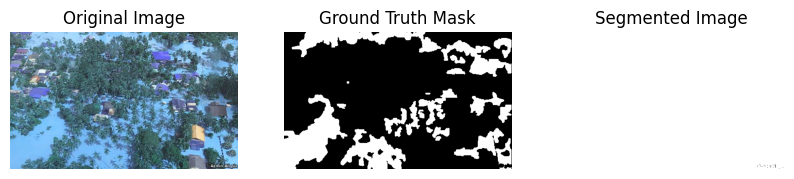

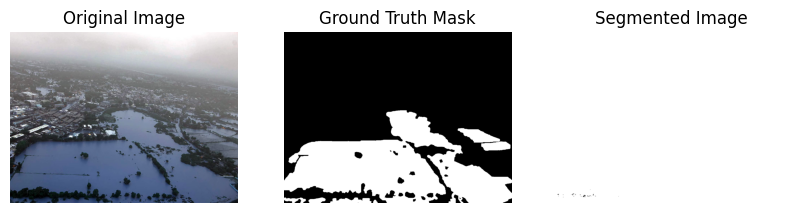

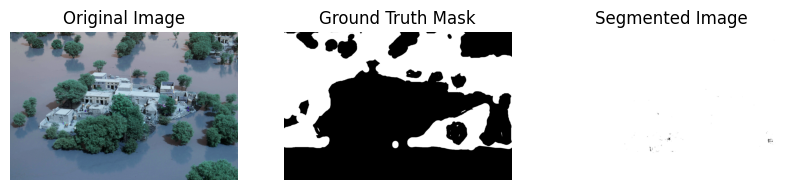

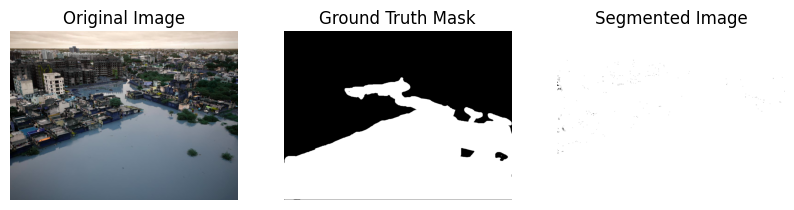

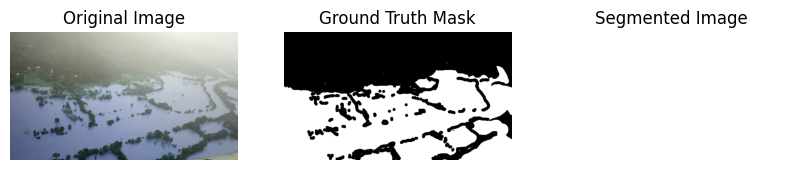

Processing for Threshold: 50


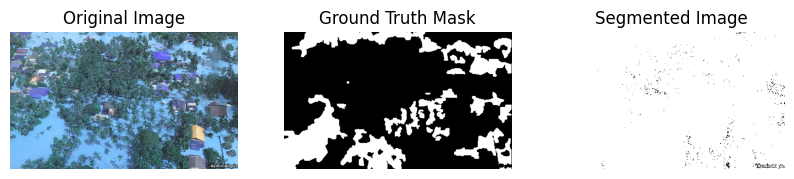

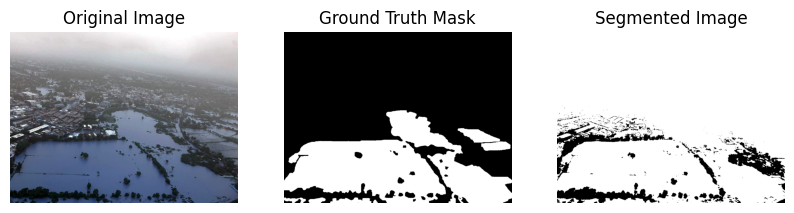

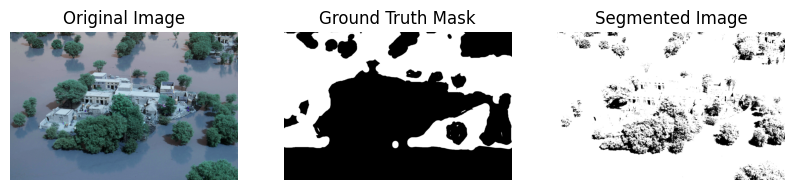

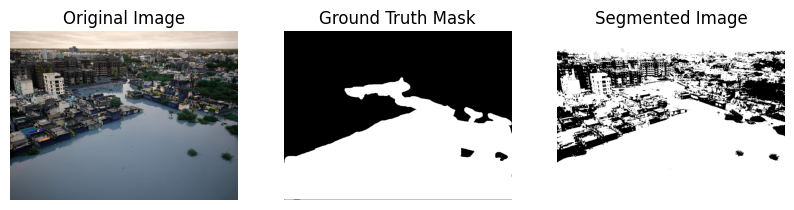

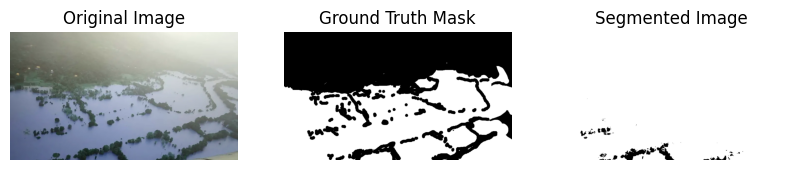

Processing for Threshold: 100


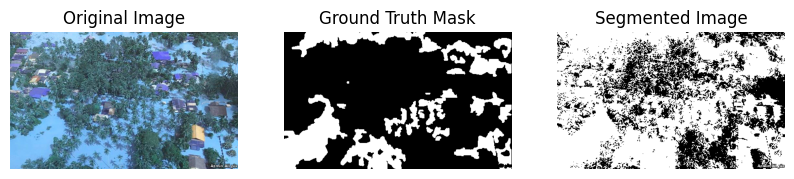

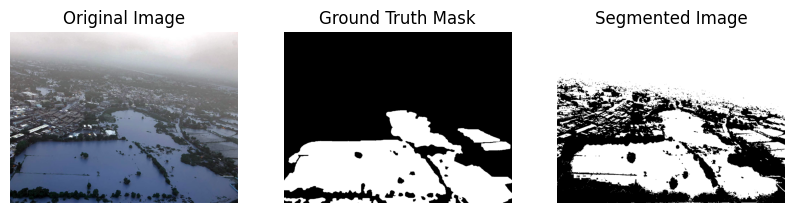

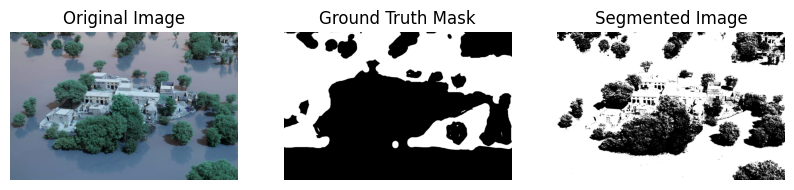

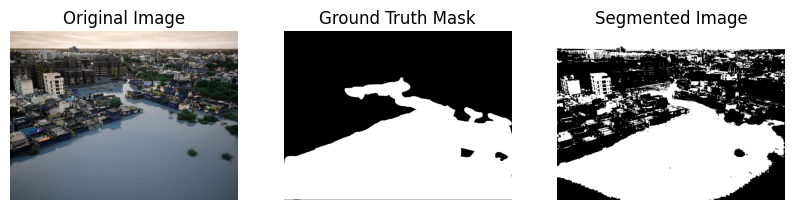

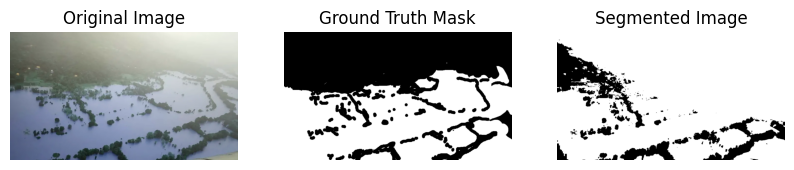

Processing for Threshold: 150


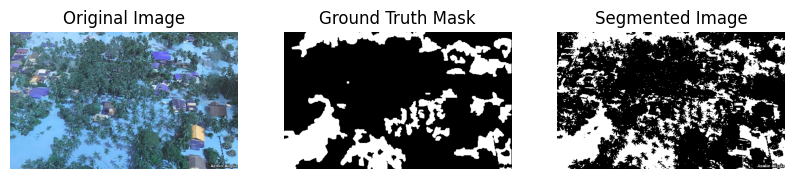

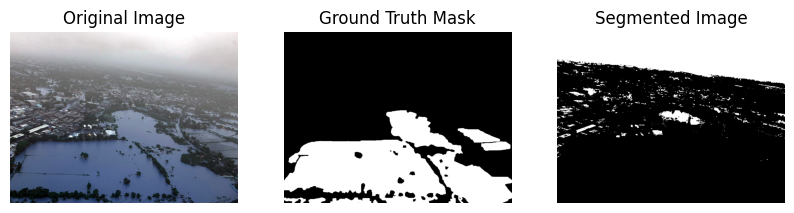

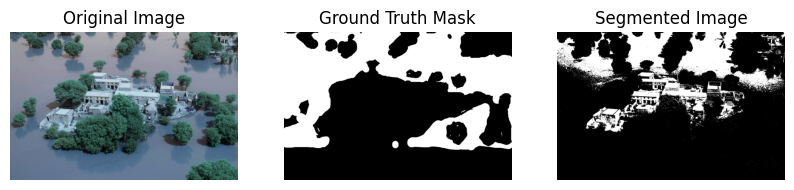

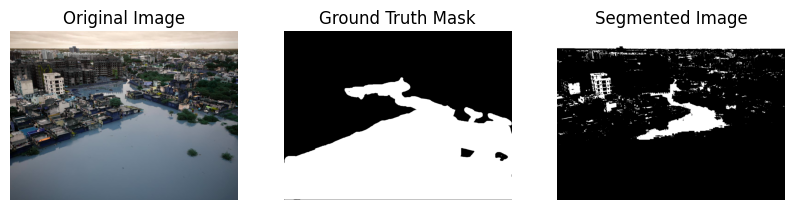

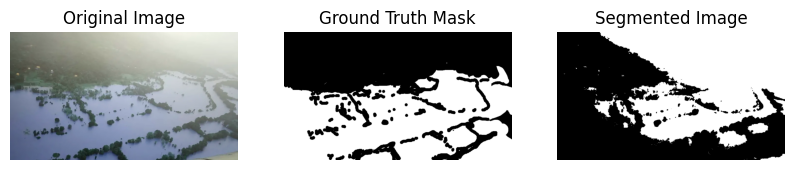

Processing for Threshold: 200


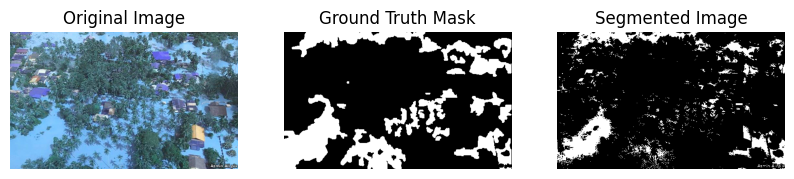

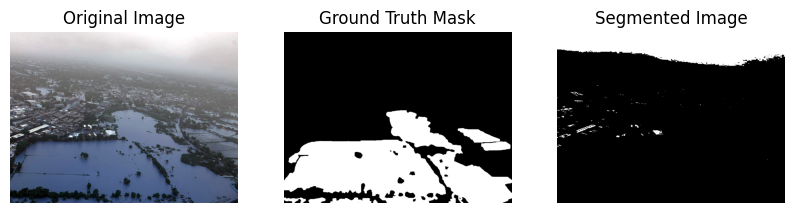

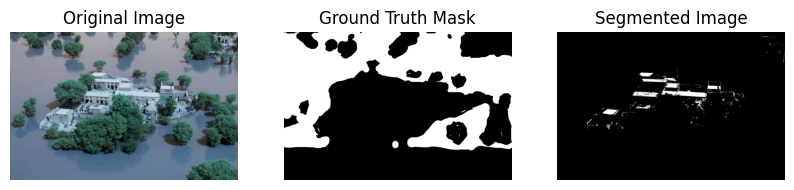

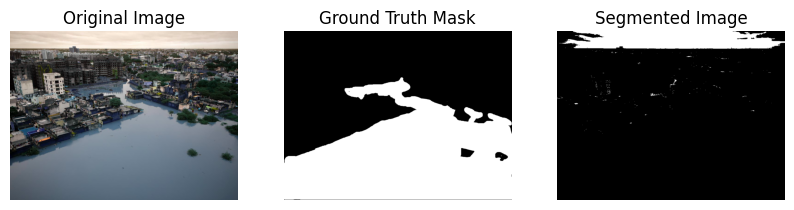

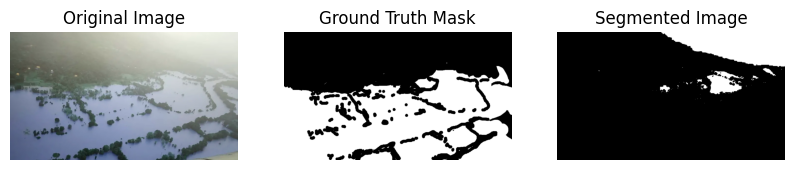

Processing for Threshold: 250


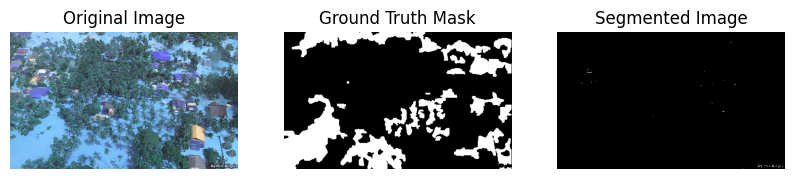

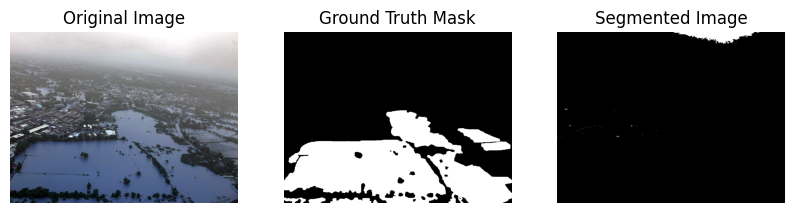

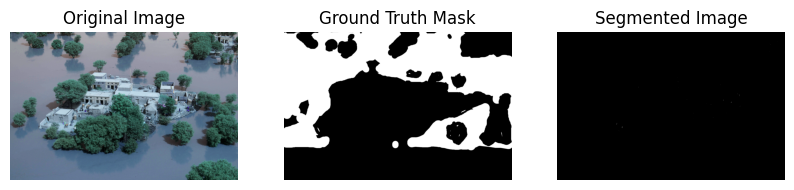

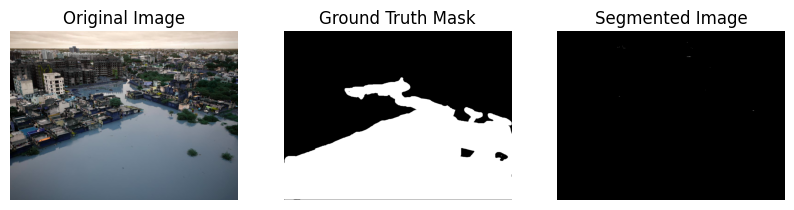

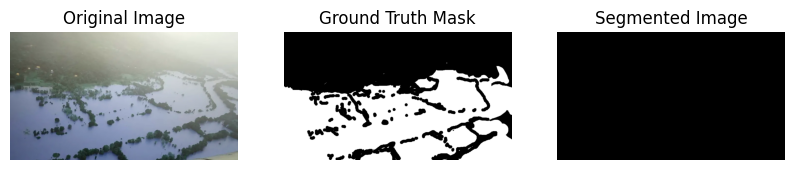

Best threshold: None
Best accuracy: 0
Threshold: 0, Accuracy: 0.0
Threshold: 0, Accuracy: 0.26886666666666664
Threshold: 0, Accuracy: 0.0
Threshold: 0, Accuracy: 0.30280277777777775
Threshold: 0, Accuracy: 0.0
Threshold: 50, Accuracy: 0.39573239976312397
Threshold: 50, Accuracy: 0.0
Threshold: 50, Accuracy: 0.46267806747347573
Threshold: 50, Accuracy: 0.0
Threshold: 50, Accuracy: 0.4808805701971939
Threshold: 100, Accuracy: 0.0
Threshold: 100, Accuracy: 0.27582666666666666
Threshold: 100, Accuracy: 0.0
Threshold: 100, Accuracy: 0.38591574074074075
Threshold: 100, Accuracy: 0.0
Threshold: 150, Accuracy: 0.469351377712753
Threshold: 150, Accuracy: 0.0
Threshold: 150, Accuracy: 0.6478766558381445
Threshold: 150, Accuracy: 0.0
Threshold: 150, Accuracy: 0.4932625595070256
Threshold: 200, Accuracy: 0.0
Threshold: 200, Accuracy: 0.5629466666666667
Threshold: 200, Accuracy: 0.0
Threshold: 200, Accuracy: 0.4541351851851852
Threshold: 200, Accuracy: 0.0
Threshold: 250, Accuracy: 0.60187271397220

In [21]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Function to resize the images to the same size
def resize_images_to_same_dimension(*images):
    # Get the minimum height and width
    min_height = min(image.shape[0] for image in images)
    min_width = min(image.shape[1] for image in images)
    
    resized_images = [cv2.resize(image, (min_width, min_height)) for image in images]
    return resized_images

# Convert the segmented image to black and white (binary)
# Convert the segmented image to black and white (binary)
def convert_to_black_and_white(image, threshold_value=0, use_otsu=False):
    # Check if the image is already grayscale (single channel)
    if len(image.shape) == 3:  # If the image has 3 channels (color image)
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        # If already grayscale, use it as it is
        gray_image = image

    # Apply thresholding to make it binary (black and white)
    if use_otsu:
        _, bw_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        _, bw_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)
    
    return bw_image


# Ensure all images are 3D (with 3 channels) for concatenation
def convert_to_three_channels(image):
    return cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Calculate pixel accuracy by comparing prediction and target
def calculate_pixel_accuracy(pred, target):
    # Ensure both images are of the same shape
    if pred.shape != target.shape:
        target = cv2.resize(target, (pred.shape[1], pred.shape[0]))  # Resize target mask to match segmented image
    
    # Flatten the arrays to 1D to avoid issues with elementwise comparison in 2D
    pred_flat = pred.flatten()
    target_flat = target.flatten()

    # Calculate accuracy by comparing pixel values
    accuracy = np.mean(pred_flat == target_flat)
    return accuracy

# Segment using specified threshold value
def segment_with_threshold(image, threshold_value):
    return convert_to_black_and_white(image, threshold_value)

# Function to display the images and calculate accuracy
def compare_with_mask(segmented_image, mask, img, accuracies):
    # Convert images to grayscale
    ground_truth_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)  # Convert mask to grayscale
    segmented_image_resized = cv2.resize(segmented_image, (ground_truth_mask.shape[1], ground_truth_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    # Resize images to the same dimension
    image_resized, mask_resized, segmented_image_resized = resize_images_to_same_dimension(img, mask, segmented_image_resized)

    # Convert the segmented image to black and white
    segmented_image_bw = convert_to_black_and_white(segmented_image_resized)
    mask_resized_bw = convert_to_black_and_white(mask_resized)

    # Convert black and white images back to 3 channels
    mask_resized_bw_3d = convert_to_three_channels(mask_resized_bw)
    segmented_image_bw_3d = convert_to_three_channels(segmented_image_bw)

    # Calculate accuracy (binary comparison)
    accuracy = calculate_pixel_accuracy(segmented_image_bw, mask_resized_bw)
    accuracies.append(accuracy)
    
    # Plot the images side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image_resized)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_resized_bw_3d, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(segmented_image_bw_3d, cmap='gray')
    plt.title("Segmented Image")
    plt.axis('off')

    plt.show()

# Main processing loop
def main():
    image_dir = 'Data/Image'  # Directory for input images
    mask_dir = 'Data/Mask'  # Directory for ground truth masks

    images = load_images(image_dir)  # Load images
    masks = load_images(mask_dir)  # Load masks

    images = images[:5]
    masks = masks[:5]

    results = {'threshold': [], 'accuracy': []}  # Store accuracy for each threshold

    best_threshold = None
    best_accuracy = 0

    # Loop through all thresholds from 0 to 255 with step 5
    for threshold in range(0, 256, 50):
        print(f"Processing for Threshold: {threshold}")
        
        # Loop through each image and corresponding mask
        for img, mask in zip(images, masks):
            # Segment the image using the current threshold
            segmented_image_bw = segment_with_threshold(img, threshold)
            
            # Ensure the mask is binary (0 and 255)
            _, mask_bw = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
            
            # Compare the binary segmented image with the mask
            accuracy = calculate_pixel_accuracy(segmented_image_bw, mask_bw)
            
            # Record the results
            results['threshold'].append(threshold)
            results['accuracy'].append(accuracy)
            
            # Check if this threshold gives the best accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_threshold = threshold

            # Display the images inline in the Jupyter Notebook
            compare_with_mask(segmented_image_bw, mask, img, results['accuracy'])

    # Print the results and best threshold
    print(f"Best threshold: {best_threshold}")
    print(f"Best accuracy: {best_accuracy}")
    
    # Optionally, print all results
    for threshold, accuracy in zip(results['threshold'], results['accuracy']):
        print(f"Threshold: {threshold}, Accuracy: {accuracy}")

# Load images function
def load_images(image_dir):
    images = []
    for filename in os.listdir(image_dir):
        img = cv2.imread(os.path.join(image_dir, filename))
        if img is not None:
            images.append(img)
    return images

# Call the main function to run the segmentation and accuracy calculation
if __name__ == "__main__":
    main()
